# Feature Evaluation

**Objective:**
Analyze **RMS**, **VAR**, and **WL** features to determine the optimal window size for maximizing Accuracy while minimizing Detection Delay.

## 1. Setup

In [18]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pathlib import Path

# Add project root to sys.path
sys.path.append(str(Path("..").resolve()))

from src import visualization, data_loader, filters, features, config

visualization.set_plot_style()

def fmt(text):
    """Wraps text in LaTeX bold only if LaTeX is available."""
    return fr"\textbf{{{text}}}" if use_tex else text

Style set. LaTeX: False


## 2. Load and Preprocess
Loading labeled data and filtering it with the optimal filter (6th Order Butterworth).

In [19]:
DATA_FILE = "../data/labeled_data.csv"
THRESHOLDS_FILE = "../results/thresholds/trained_thresholds.csv"

# 1. Load Test Data
df = data_loader.load_labeled_csv(DATA_FILE)
# Convert to Voltage (0-5V)
raw_signal = (df['RawValue'] / 1023.0 * config.V_REF).values
raw_signal = raw_signal - np.mean(raw_signal)
labels = df['LabelNumeric'].values

# Filter (4th Order to match training config)
clean_signal = filters.apply_butterworth_sos(raw_signal, order=4, fs=config.FS)

# 2. Load Trained Thresholds
if not os.path.exists(THRESHOLDS_FILE):
    raise FileNotFoundError(f"Missing {THRESHOLDS_FILE}. Please run training or copy the file.")

df_thresholds = pd.read_csv(THRESHOLDS_FILE)
print("Loaded Data and Trained Thresholds.")

Loaded Data and Trained Thresholds.


## 3. Window Size Optimization
Calculating Accuracy and Detection Delay for window sizes 30ms - 200ms.

In [20]:
window_sizes = range(30, 201, 10)
results = {'RMS': [], 'VAR': [], 'WL': []}
delays = {'RMS': [], 'VAR': [], 'WL': []}

feature_funcs = {'RMS': features.calculate_rms, 'VAR': features.calculate_var, 'WL': features.calculate_wl}

def get_trained_threshold(feat, win_ms):
    """Looks up the threshold from the CSV."""
    row = df_thresholds[
        (df_thresholds["Feature"] == feat) & 
        (df_thresholds["WindowSize(ms)"] == win_ms)
    ]
    if row.empty:
        return None
    return row["Threshold"].values[0]

def calculate_delay_ms(y_true, y_pred, fs):
    """Calculates average delay in milliseconds."""
    delays = []
    in_event = False
    start_idx = 0
    
    for i in range(1, len(y_true)):
        # Onset of contraction (Label 0 -> 1)
        if y_true[i-1] == 0 and y_true[i] == 1:
            in_event = True
            start_idx = i
        
        # First detection by algorithm (Prediction 1)
        if in_event and y_pred[i] == 1:
            # Found it! Calculate time diff
            delay = (i - start_idx) / fs * 1000.0
            delays.append(delay)
            in_event = False # Stop looking for this event
            
    return np.mean(delays) if delays else 0.0

print("Evaluating System Performance...")

for win in window_sizes:
    samples = int(win * config.FS / 1000)
    target_labels = labels[samples-1:] 
    
    for name, func in feature_funcs.items():
        # 1. Lookup Threshold (Do not optimize!)
        thresh = get_trained_threshold(name, win)
        
        if thresh is None:
            # Fallback if specific window missing in CSV
            results[name].append(0)
            delays[name].append(0)
            continue
            
        # 2. Calculate Feature
        feats = func(clean_signal, samples)
        
        # 3. Apply Threshold
        preds = (feats >= thresh).astype(int)
        
        # 4. Calculate Metrics
        acc = accuracy_score(target_labels, preds)
        delay = calculate_delay_ms(target_labels, preds, config.FS)
        
        results[name].append(acc * 100)
        delays[name].append(delay)

print("Evaluation Complete.")

Evaluating System Performance...
Evaluation Complete.


## 4. Results Plotting
Visualizing the trade-off between Accuracy and Delay.

Saved [DRAFT]: ../results/drafts/validation_accuracy_delay.png


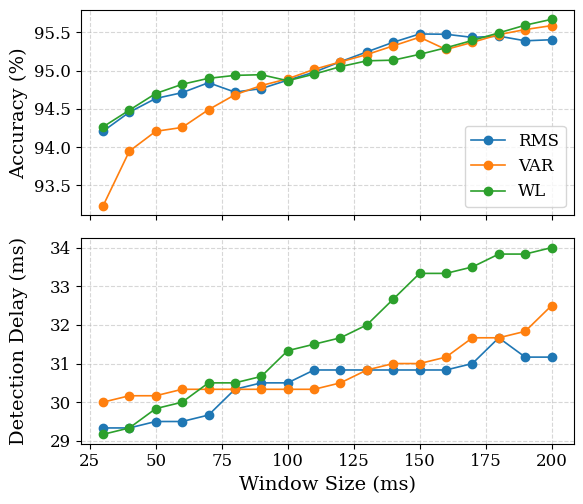

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5.2), sharex=True)

# Top: Accuracy
for name in ['RMS', 'VAR', 'WL']:
    ax1.plot(window_sizes, results[name], marker='o', label=name, color=visualization.COLORS[name])

ax1.set_ylabel(fmt("Accuracy (%)"))
ax1.grid(True)
ax1.legend()
# ax1.set_ylim(90, 100) # Uncomment if you want to zoom in

# Bottom: Delay
for name in ['RMS', 'VAR', 'WL']:
    ax2.plot(window_sizes, delays[name], marker='o', label=name, color=visualization.COLORS[name])

ax2.set_ylabel(fmt("Detection Delay (ms)"))
ax2.set_xlabel(fmt("Window Size (ms)"))
ax2.grid(True)

fig.align_ylabels()
plt.tight_layout()

visualization.save_fig(fig, 'validation_accuracy_delay.png')
plt.show()